# 2016 US Bike Share Activity Snapshot

## Table of Contents
- [Introduction](#intro)
- [Posing Questions](#pose_questions)
- [Data Collection and Wrangling](#wrangling)
  - [Condensing the Trip Data](#condensing)
- [Exploratory Data Analysis](#eda)
  - [Statistics](#statistics)
  - [Visualizations](#visualizations)
- [Performing more Analysis](#eda_continued)


<a id='intro'></a>
## Introduction



Over the past decade, bicycle-sharing systems have been growing in number and popularity in cities across the world. Bicycle-sharing systems allow users to rent bicycles for short trips, typically 30 minutes or less. Thanks to the rise in information technologies, it is easy for a user of the system to access a dock within the system to unlock or return bicycles. These technologies also provide a wealth of data that can be used to explore how these bike-sharing systems are used.

In this project, we will perform an exploratory analysis on data provided by [Motivate](https://www.motivateco.com/), a bike-share system provider for many major cities in the United States. We will compare the system usage between three large cities: New York City, Chicago, and Washington, DC. We will also see if there are any differences within each system for those users that are registered, regular users and those users that are short-term, casual users.

<a id='pose_questions'></a>
## Posing Questions

Before looking at the bike sharing data, we should start by asking questions we might want to understand about the bike share data. Consider, for example, if we were working for Motivate. What kinds of information would we want to know about in order to make smarter business decisions? If we were a user of the bike-share service, what factors might influence how we would want to use the service?

Here are questions related to bike sharing that I think could be answered by data.

 
            1. Which city has the highest number of trips? 
            2. Which city has the highest proportion of trips made by subscribers? 
            3. Which city has the highest proportion of trips made by short-term customers?
            4. What is the average trip length for each city? 
            5. What proportion of rides made in each city are longer than 30 minutes? 
            5. Which type of user takes longer rides on average: Subscribers or Customers in a perticular city?
            6. During what time of day is the system used the most?
            7. Is there a difference in usage patterns for Subscribers and Customers?


<a id='wrangling'></a>
## Data Collection and Wrangling

Now it's time to collect and explore our data. In this project, we will focus on the record of individual trips taken in 2016 from our selected cities: New York City, Chicago, and Washington, DC. Each of these cities has a page where we can freely download the trip data.:

- New York City (Citi Bike): [Link](https://www.citibikenyc.com/system-data)
- Chicago (Divvy): [Link](https://www.divvybikes.com/system-data)
- Washington, DC (Capital Bikeshare): [Link](https://www.capitalbikeshare.com/system-data)

If we visit these pages, we will notice that each city has a different way of delivering its data. Chicago updates with new data twice a year, Washington DC is quarterly, and New York City is monthly. **However, you do not need to download the data yourself.** The data has already been collected for you in the `/data/` folder of the project files. While the original data for 2016 is spread among multiple files for each city, the files in the `/data/` folder collect all of the trip data for the year into one file per city. Some data wrangling of inconsistencies in timestamp format within each city has already been performed. In addition, a random 2% sample of the original data is taken to make the exploration more manageable. 

However, there is still a lot of data for us to investigate, so it's a good idea to start off by looking at one entry from each of the cities we're going to analyze.

In [1]:
## import all necessary packages and functions.
import csv # read and write csv files
from datetime import datetime , date# operations to parse dates
from pprint import pprint # use to print data structures like dictionaries in
                          # a nicer way than the base print function.

In [2]:
def print_first_point(filename):
    """
    This function prints and returns the first data point (second row) from
    a csv file that includes a header row.
    """
    # print city name for reference
    city = filename.split('-')[0].split('/')[-1]
    print('\nCity: {}'.format(city))
    
    with open(filename, 'r') as f_in:
        
        ## see https://docs.python.org/3/library/csv.html           ##
        trip_reader = csv.DictReader(f_in)
        
        
        ## see https://docs.python.org/3/library/csv.html#reader-objects ##
        first_trip = trip_reader.__next__()
        
        
        ## see https://docs.python.org/3/library/pprint.html     ##
        pprint(first_trip)
   
    # output city name and first trip for later testing
    return (city, first_trip)

# list of files for each city
data_files = ['./data/NYC-CitiBike-2016.csv',
              './data/Chicago-Divvy-2016.csv',
              './data/Washington-CapitalBikeshare-2016.csv',]

# print the first trip from each file, store in dictionary
example_trips = {}
for data_file in data_files:
    city, first_trip = print_first_point(data_file)
    example_trips[city] = first_trip


City: NYC
OrderedDict([('tripduration', '839'),
             ('starttime', '1/1/2016 00:09:55'),
             ('stoptime', '1/1/2016 00:23:54'),
             ('start station id', '532'),
             ('start station name', 'S 5 Pl & S 4 St'),
             ('start station latitude', '40.710451'),
             ('start station longitude', '-73.960876'),
             ('end station id', '401'),
             ('end station name', 'Allen St & Rivington St'),
             ('end station latitude', '40.72019576'),
             ('end station longitude', '-73.98997825'),
             ('bikeid', '17109'),
             ('usertype', 'Customer'),
             ('birth year', ''),
             ('gender', '0')])

City: Chicago
OrderedDict([('trip_id', '9080545'),
             ('starttime', '3/31/2016 23:30'),
             ('stoptime', '3/31/2016 23:46'),
             ('bikeid', '2295'),
             ('tripduration', '926'),
             ('from_station_id', '156'),
             ('from_station_name', 'Clar

If everything has been filled out correctly, we should see below the printout of each city name (which has been parsed from the data file name) that the first trip has been parsed in the form of a dictionary. When we set up a `DictReader` object, the first row of the data file is normally interpreted as column names. Every other row in the data file will use those column names as keys, as a dictionary is generated for each row.

This will be useful since we can refer to quantities by an easily-understandable label instead of just a numeric index. For example, if we have a trip stored in the variable `row`, then we would rather get the trip duration from `row['duration']` instead of `row[0]`.

<a id='condensing'></a>
### Condensing the Trip Data

It should also be observable from the above printout that each city provides different information. Even where the information is the same, the column names and formats are sometimes different. To make things as simple as possible when we get to the actual exploration, we should trim and clean the data. Cleaning the data makes sure that the data formats across the cities are consistent, while trimming focuses only on the parts of the data we are most interested in to make the exploration easier to work with.

We will generate new data files with five values of interest for each trip: trip duration, starting month, starting hour, day of the week, and user type. Each of these may require additional wrangling depending on the city:

- **Duration**: This has been given to us in seconds (New York, Chicago) or milliseconds (Washington). A more natural unit of analysis will be if all the trip durations are given in terms of minutes.
- **Month**, **Hour**, **Day of Week**: Ridership volume is likely to change based on the season, time of day, and whether it is a weekday or weekend.We use the start time of the trip to obtain these values. The New York City data includes the seconds in their timestamps, while Washington and Chicago do not. The [`datetime`](https://docs.python.org/3/library/datetime.html) package will be very useful here to make the needed conversions.
- **User Type**: It is possible that users who are subscribed to a bike-share system will have different patterns of use compared to users who only have temporary passes. Washington divides its users into two types: 'Registered' for users with annual, monthly, and other longer-term subscriptions, and 'Casual', for users with 24-hour, 3-day, and other short-term passes. The New York and Chicago data uses 'Subscriber' and 'Customer' for these groups, respectively. For consistency, we will convert the Washington labels to match the other two.


Now its time to complete the helper functions in the code cells below to address each of the cleaning tasks described above.

In [3]:
def duration_in_mins(datum, city):
    """
    Takes as input a dictionary containing info about a single trip (datum) and
    its origin city (city) and returns the trip duration in units of minutes.
    
    Remember that Washington is in terms of milliseconds while Chicago and NYC
    are in terms of seconds. 
    
    The csv module reads in all of the data as strings, including numeric
    values. We will need a function to convert the strings into an appropriate
    numeric type when making your transformations.
    see https://docs.python.org/3/library/functions.html
    """
    
    
    if city == 'Washington':
        duration = float(datum['Duration (ms)']) / 60000
    else:
        duration = float(datum['tripduration']) / 60
    return duration


# Some tests to check that the code works. There should be no output if all of
# the assertions pass. The `example_trips` dictionary was obtained from when
# we printed the first trip from each of the original data files.
tests = {'NYC': 13.9833,
         'Chicago': 15.4333,
         'Washington': 7.1231}

for city in tests:
    
    assert abs(duration_in_mins(example_trips[city], city) - tests[city]) < .001

In [4]:
def time_of_trip(datum, city):
    """
    Takes as input a dictionary containing info about a single trip (datum) and
    its origin city (city) and returns the month, hour, and day of the week in
    which the trip was made.
    
    Remember that NYC includes seconds, while Washington and Chicago do not.
    
    We should use the datetime module to parse the original date
    strings into a format that is useful for extracting the desired information.
    see https://docs.python.org/3/library/datetime.html#strftime-and-strptime-behavior
    """
    #month/date/year hr:min
    # m - month , d- day, Y- year, S- seconds, H - Hours, M - minutes
    
    if city == 'NYC':
        a = datetime.strptime(datum['starttime'] , '%m/%d/%Y %H:%M:%S')
        
    elif city =='Chicago':
        a = datetime.strptime(datum['starttime'], '%m/%d/%Y %H:%M')

    else:
        a = datetime.strptime(datum['Start date'], '%m/%d/%Y %H:%M')

    month = a.month
    hour = a.hour
    day_of_week = a.strftime('%A')
    return (month, hour, day_of_week)

# Some tests to check that the code works. There should be no output if all of
# the assertions pass. The `example_trips` dictionary was obtained from when
# we printed the first trip from each of the original data files.
tests = {'NYC': (1, 0, 'Friday'),
         'Chicago': (3, 23, 'Thursday'),
         'Washington': (3, 22, 'Thursday')}

for city in tests:
    
    assert time_of_trip(example_trips[city], city) == tests[city]

In [5]:
def type_of_user(datum, city):
    """
    Takes as input a dictionary containing info about a single trip (datum) and
    its origin city (city) and returns the type of system user that made the
    trip.
    
    Remember that Washington has different category names compared to Chicago
    and NYC. 
    """

    if city == 'Washington':
        ab = datum['Member Type']
        if ab == 'Registered': 
            user_type = 'Subscriber'
        elif ab == 'Casual':
            user_type = 'Customer'
    else:
        user_type = datum['usertype']
        
    return user_type


# Some tests to check that your code works. There should be no output if all of
# the assertions pass. The `example_trips` dictionary was obtained from when
# we printed the first trip from each of the original data files.
tests = {'NYC': 'Customer',
         'Chicago': 'Subscriber',
         'Washington': 'Subscriber'}

for city in tests:
    assert type_of_user(example_trips[city], city) == tests[city]

Now, using the helper functions we wrote above, we will create a condensed data file for each city consisting only of the data fields indicated above.

In [6]:
def condense_data(in_file, out_file, city):
    """
    This function takes full data from the specified input file
    and writes the condensed data to a specified output file. The city
    argument determines how the input file will be parsed.
    
    """
    
    with open(out_file, 'w') as f_out, open(in_file, 'r') as f_in:
        # set up csv DictWriter object - writer requires column names for the
        # first row as the "fieldnames" argument
        out_colnames = ['duration', 'month', 'hour', 'day_of_week', 'user_type']        
        trip_writer = csv.DictWriter(f_out, fieldnames = out_colnames)
        trip_writer.writeheader()
        
        
        trip_reader = csv.DictReader(f_in)

        # collect data from and process each row
        for row in trip_reader:
            # set up a dictionary to hold the values for the cleaned and trimmed
            # data point
            new_point = {}

            ## using the helper functions to get the cleaned data from      ##
            ## the original data dictionaries.                              ##
            ## Note that the keys for the new_point dictionary should match ##
            ## the column names set in the DictWriter object above.         ##
            new_point['duration'] = duration_in_mins(row, city)
            new_point['month'], new_point['hour'], new_point['day_of_week'] = time_of_trip(row, city)
            new_point['user_type'] = type_of_user(row, city)
            
            ## Writing the processed information to the output file.         ##
            ## see https://docs.python.org/3/library/csv.html#writer-objects ##
            trip_writer.writerow(new_point)
            
            

In [7]:

city_info = {'Washington': {'in_file': './data/Washington-CapitalBikeshare-2016.csv',
                            'out_file': './data/Washington-2016-Summary.csv'},
             'Chicago': {'in_file': './data/Chicago-Divvy-2016.csv',
                         'out_file': './data/Chicago-2016-Summary.csv'},
             'NYC': {'in_file': './data/NYC-CitiBike-2016.csv',
                     'out_file': './data/NYC-2016-Summary.csv'}}

for city, filenames in city_info.items():
    condense_data(filenames['in_file'], filenames['out_file'], city)
    print_first_point(filenames['out_file'])


City: Washington
OrderedDict([('duration', '7.123116666666666'),
             ('month', '3'),
             ('hour', '22'),
             ('day_of_week', 'Thursday'),
             ('user_type', 'Subscriber')])

City: Chicago
OrderedDict([('duration', '15.433333333333334'),
             ('month', '3'),
             ('hour', '23'),
             ('day_of_week', 'Thursday'),
             ('user_type', 'Subscriber')])

City: NYC
OrderedDict([('duration', '13.983333333333333'),
             ('month', '1'),
             ('hour', '0'),
             ('day_of_week', 'Friday'),
             ('user_type', 'Customer')])


<a id='eda'></a>
## Exploratory Data Analysis

Now that we have the data collected and wrangled, we're ready to start exploring the data. In this section we will write some code to compute descriptive statistics from the data. We will also be introduced to the `matplotlib` library to create some basic histograms of the data.

<a id='statistics'></a>
### Statistics

First, let's compute some basic counts. The first cell below contains a function that uses the csv module to iterate through a provided data file, returning the number of trips made by subscribers and customers.

**Question 1a**: Which city has the highest number of trips? 

**Answer**: City with highest number of trips : NYC (276798)

**Question 1b**: Which city has the highest proportion of trips made by subscribers? 

**Answer**: City with highest proportion of trips made by subscribers : NYC (88.83%)

**Question 1c**: Which city has the highest proportion of trips made by short-term customers?

**Answer**: city with highest proportion of trips made by customers : Chicago (23.78%)
 
    

In [8]:
def number_of_trips(filename):
    """
    This function reads in a file with trip data and reports the number of
    trips made by subscribers, customers, and total overall.
    """
    with open(filename, 'r') as f_in:
        # set up csv reader object
        reader = csv.DictReader(f_in)
        
        # initialize count variables
        n_subscribers = 0
        n_customers = 0
        
        # tally up ride types
        for row in reader:
            if row['user_type'] == 'Subscriber':
                n_subscribers += 1
            else:
                n_customers += 1
        
        # compute total number of rides
        n_total = n_subscribers + n_customers
        
        # return tallies as a tuple
        return(n_subscribers, n_customers, n_total)

In [9]:
data_file = './data/Chicago-2016-Summary.csv'
print('Chicago: ',number_of_trips(data_file))
data_file = './data/NYC-2016-Summary.csv'
print('NYC: ',number_of_trips(data_file))
data_file = './data/Washington-2016-Summary.csv'
print('Washington: ',number_of_trips(data_file))

Chicago:  (54982, 17149, 72131)
NYC:  (245896, 30902, 276798)
Washington:  (51753, 14573, 66326)


**Question 2**: Bike-share systems are designed for riders to take short trips. Most of the time, users are allowed to take trips of 30 minutes or less with no additional charges, with overage charges made for trips of longer than that duration. What is the average trip length for each city? What proportion of rides made in each city are longer than 30 minutes?

**Answer**: 
    1. The average trip length of Chicago :  16.563629368787335
    2. The average trip length of NYC :  15.81259299802294
    3. The average trip length of Washington :  18.93287355913721

    1. Proportion of trips longer than 30 min in Chicago:  8.34731252859381 %
    2. Proportion of trips longer than 30 min in NYC:  7.316888127804392 %
    3. Proportion of trips longer than 30 min in Washington:  10.83888671109369 %

In [10]:
def convert_to_numeric(value):
    '''This function convert strings to numeric value'''
    return float(value)

In [11]:
def average_trip_length(filename):
    '''This fuction is to calculate the avarage'''
    with open(filename, 'r') as f_in:
        # set up csv reader object
        reader = csv.DictReader(f_in)
        
        row_count = 0 
        sum = 0
        
        
        for row in reader:
            for value in row['duration'].split('\n'):
                
                a = convert_to_numeric(value)
                sum = sum + a
                row_count = row_count + 1
        
    avarage = sum / row_count
    return avarage

In [12]:
data_file = './data/Chicago-2016-Summary.csv'
print('The average trip length of Chicago : ',average_trip_length(data_file))
data_file = './data/NYC-2016-Summary.csv'
print('The average trip length of NYC : ',average_trip_length(data_file))
data_file = './data/Washington-2016-Summary.csv'
print('The average trip length of Washington : ',average_trip_length(data_file))

The average trip length of Chicago :  16.563629368787335
The average trip length of NYC :  15.81259299802294
The average trip length of Washington :  18.93287355913721


In [13]:
def prop_of_length_more_30min(filename):
    
    '''This function is to calulate the proportion 
    of trips that are over 30 min in a city'''
    
    with open(filename, 'r') as f_in:
        reader = csv.DictReader(f_in)
        
        row_count = 0
        case_count = 0
        
        for row in reader:
            for value in row['duration'].split('\n'):
                a = convert_to_numeric(value)
                if a  >= 30.0:
                    case_count += 1
                row_count += 1
    
    proportion = (case_count/row_count)*100
    
    return proportion
    

In [14]:
data_file = './data/Chicago-2016-Summary.csv'
print('Proportion of trips longer than 30 min in Chicago: ', prop_of_length_more_30min(data_file))
data_file = './data/NYC-2016-Summary.csv'
print('Proportion of trips longer than 30 min in NYC: ', prop_of_length_more_30min(data_file))
data_file = './data/Washington-2016-Summary.csv'
print('Proportion of trips longer than 30 min in Washington: ', prop_of_length_more_30min(data_file))

Proportion of trips longer than 30 min in Chicago:  8.34731252859381
Proportion of trips longer than 30 min in NYC:  7.316888127804392
Proportion of trips longer than 30 min in Washington:  10.83888671109369


**Question 3**: Digging deeper into the question of trip duration based on ridership. Choosing one city. Within that city, which type of user takes longer rides on average: Subscribers or Customers?

**Answer**: 
    1. Chicago: (My case of study)
        The avarage trip of Subscribers: 12.067201690250076
        The average trip of customers: 30.979781133982506 
        Type of users took longer rides: Customers
        
    2. NYC:  
        The avarage trip of Subscribers: 13.680790523907177
        The average trip of customers: 32.77595139473187 
        Type of users took longer rides: Customers
        
    3. Washington:
        The avarage trip of Subscribers: 12.528120499294745
        The average trip of customers: 41.67803139252976
        Type of users took longer rides: Customers
        
 My case of study will be on **Chicago**, further answers will be answered based on **Chicago's** data.

In [15]:
def avg_trips_sub_Vs_cus(filename):
    '''This function finds the average trip made by Subscribers and Customers
    and finds who made the longest in average'''
    
    with open(filename, 'r') as f_in:
        reader = csv.DictReader(f_in)
        
        sub_count = 0
        cus_count = 0
        sub_sum = 0
        cus_sum = 0
        
        for row in reader:
            for value in row['duration'].split('\n'):
                a = convert_to_numeric(value)
                if row['user_type'] == 'Subscriber':
                    sub_sum += a
                    sub_count += 1
                else:
                    cus_sum += a
                    cus_count += 1
                
        avg_cus = cus_sum / cus_count
        avg_sub = sub_sum / sub_count
    
    if(avg_cus > avg_sub):
        Best = 'Customers'
    else:
        Best = 'Subscribers'
        
    return('The avarage trip of Subscribers:',avg_sub,
           'The average trip of customers:', avg_cus,
           'The '
           'type of users took longer rides:', Best )


In [16]:
data_file = './data/Chicago-2016-Summary.csv'
print('Chicago: ', avg_trips_sub_Vs_cus(data_file))
data_file = './data/NYC-2016-Summary.csv'
print('NYC: ', avg_trips_sub_Vs_cus(data_file))
data_file = './data/Washington-2016-Summary.csv'
print('Washington: ', avg_trips_sub_Vs_cus(data_file))

Chicago:  ('The avarage trip of Subscribers:', 12.067201690250076, 'The average trip of customers:', 30.979781133982506, 'The type of users took longer rides:', 'Customers')
NYC:  ('The avarage trip of Subscribers:', 13.680790523907177, 'The average trip of customers:', 32.77595139473187, 'The type of users took longer rides:', 'Customers')
Washington:  ('The avarage trip of Subscribers:', 12.528120499294745, 'The average trip of customers:', 41.67803139252976, 'The type of users took longer rides:', 'Customers')


<a id='visualizations'></a>
### Visualizations

The last set of values that we computed has pulled up an interesting result. While the mean trip time for Subscribers is well under 30 minutes, the mean trip time for Customers is actually _above_ 30 minutes! It will be interesting for us to look at how the trip times are distributed.

**Question 4**:For each group (Subscribers and customers), where is the peak of each distribution? How would we describe the shape of each distribution?

**Answer**: 
    
   **Subscribers:**
    * The graph is Right Skewed Distribution graph
    * The Peak in Subscribers is in between 5 min to 10 minutes
    
   **Customers**
    * The Graph is Right Skewed Distribution graph
    * The peak in Customers is in between 20 to 25 minutes

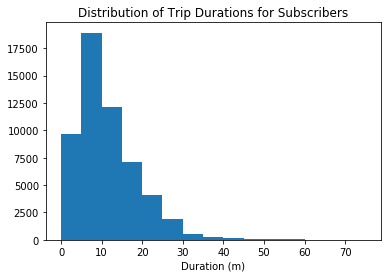

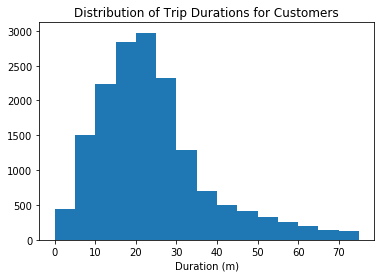

In [17]:
import matplotlib.pyplot as plt

%matplotlib inline 

data_Subscriber = []
data_Customer = []
# to load values of duration of Chicago data to the list 'data'.
with open('./data/Chicago-2016-Summary.csv', 'r') as f_in:
        
        reader = csv.DictReader(f_in)
        
        for row in reader:
            for value in row['duration'].split('\n'):
                a = convert_to_numeric(value)
                if row['user_type'] == 'Subscriber':
                    data_Subscriber.append(a) #Adding values to the Subscriber list
                else:
                    data_Customer.append(a) #Adding values to Customer list
                
                
plt.hist(data_Subscriber, range = [ 0, 75], bins=[0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75])
plt.title('Distribution of Trip Durations for Subscribers')
plt.xlabel('Duration (m)')
plt.show()

plt.hist(data_Customer, range = [ 0, 75], bins=[0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75])
plt.title('Distribution of Trip Durations for Customers')
plt.xlabel('Duration (m)')
plt.show()

<a id='eda_continued'></a>
## Performing more Analysis

So far, we've performed an initial exploration into the data available. We have compared the relative volume of trips made between three U.S. cities and the ratio of trips made by Subscribers and Customers. For one of these cities, we have investigated differences between Subscribers and Customers in terms of how long a typical trip lasts.

**Question 5**:During what time of day is the system used the most? Is there a difference in usage patterns for Subscribers and Customers?

**Answer**: In Chicago city, During 17:00 to 17:59 hours, the system is used the most. There is lot of differences in usage patterns for Subcribers and customers. 

**Subcribers** graph shows some what **Double-peaked or bimodal type of distributions**, which mean subscribers choose to ride bikes a lot somewhere between 7 hours to 9 hours and a lot between 17 hours to 19 hours, remaining time, the bike rides are somewhat study, while between 0 hours to 6 hours, the intensity is too low  

**Customers** graph tend to be **Left Skewed Distribution**, which means customers tend to use bycyles starting from 6 hour, gradually increasing and reach a peak in 15 hrs and slowly decrease in curve till 24 hrs.



In [18]:
from collections import Counter

def time_of_day_most_used(filename):
    '''This function finds the time in a day where the bycycles are most used'''
    with open(filename, 'r') as f_in:
        reader = csv.DictReader(f_in)
        
        hour_list = []
        for row in reader:
            for value in row['hour'].split('\n'):
                a = int(value)
                hour_list.append(a)
        
    cnt = Counter(hour_list)
    return (cnt.most_common(1)) #returns top 1 hour where riders took bike the most   


In [19]:
data_file = './data/Chicago-2016-Summary.csv'
print('Chicago: ', time_of_day_most_used(data_file))

Chicago:  [(17, 8564)]


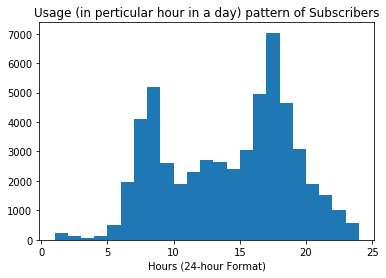

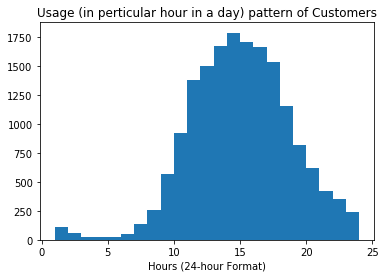

In [20]:
#import matplotlib.pyplot as plt

#%matplotlib inline 

data_Subscriber = []
data_Customer = []
# to load values of duration of Chicago data to the list 'data'.
with open('./data/Chicago-2016-Summary.csv', 'r') as f_in:
        
        reader = csv.DictReader(f_in)
        
        for row in reader:
            for value in row['hour'].split('\n'):
                a = int(value)
                if row['user_type'] == 'Subscriber':
                    data_Subscriber.append(a) #Adding values to the Subscriber list
                else:
                    data_Customer.append(a) #Adding values to Customer list
                
                
plt.hist(data_Subscriber, range = [ 0, 24], bins=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24])
plt.title('Usage (in perticular hour in a day) pattern of Subscribers')
plt.xlabel('Hours (24-hour Format)')
plt.show()

plt.hist(data_Customer, range = [ 0, 24], bins=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24])
plt.title('Usage (in perticular hour in a day) pattern of Customers')
plt.xlabel('Hours (24-hour Format)')
plt.show()